In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cenpy
import geopandas
import matplotlib
import requests
from config import apiKey

In [3]:
# get data from API using requests method
def get_request(url, parameters = {}):
    return requests.get(url, params = parameters)
url = "https://api.census.gov/data/2018/abscs"
params = {
            "get": "STATE,NAME,EMP,ETH_GROUP,RACE_GROUP,RCPPDEMP",
            "for": "state",
            "key": apiKey
        }
res = get_request(url, params).json()
abscs = pd.DataFrame(res[1:], columns = res[0])
abscs["STATE"] = abscs["STATE"].astype(int)
abscs.head()

,STATE,NAME,EMP,ETH_GROUP,RACE_GROUP,RCPPDEMP,state
0,28,Mississippi,4390,020,00,0,28
1,28,Mississippi,457023,001,92,0,28
2,28,Mississippi,0,020,40,0,28
3,28,Mississippi,13204,029,40,0,28
4,28,Mississippi,0,028,00,0,28


In [86]:
# # get data from API using cenpy
# shortCodes = cenpy.explorer.available()
# shortCodes.loc["ABSCS2019"]

# # query 2019 Anual Business Survey census tables 
# conn = cenpy.remote.APIConnection("ABSCS2019")

# # view variables
# # searching as "ABSCS2019"
# variables = conn.variables
# #variables.head()

# # query the 2020 5-year ACS for median income and margin of error, using zip code as the aggregation geography
# names = ["STATE", "EMP", "ETH_GROUP", "RACE_GROUP", "RCPPDEMP"]
# business = conn.query(names, geo_unit='state')
# # income.rename(columns={'B19013_001E': 'income', 'B19013_001M': 'margin of error'}, inplace=True)
# # income['income'] = income['income'].astype(float)
# # income['margin of error'] = income['margin of error'].astype(float)
# # change data type of state column to int
# business["STATE"] = business["STATE"].astype(int)

In [4]:
# load states FIPS for merge
states = pd.read_csv("stateFIPS.txt", sep = "|")
states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   STATE       57 non-null     int64 
 1   STUSAB      57 non-null     object
 2   STATE_NAME  57 non-null     object
 3   STATENS     57 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.9+ KB


In [5]:
# merge state FIPS to business dataframe
busState = abscs.merge(states[["STATE_NAME", "STATE"]], left_on = "STATE", right_on = "STATE")
busState.head()

,STATE,NAME,EMP,ETH_GROUP,RACE_GROUP,RCPPDEMP,state,STATE_NAME
0,28,Mississippi,4390,020,00,0,28,Mississippi
1,28,Mississippi,457023,001,92,0,28,Mississippi
2,28,Mississippi,0,020,40,0,28,Mississippi
3,28,Mississippi,13204,029,40,0,28,Mississippi
4,28,Mississippi,0,028,00,0,28,Mississippi


In [6]:
# use dictionaries to map codes to names, codes on: https://www2.census.gov/programs-surveys/abs/technical-documentation/api/ABS_API_CB-10-4-2021.pdf
eth_group = {"001": "Total", "020": "Hispanic", "028": "Equally Hispanic/non-Hispanic", "029": "Non-Hispanic", "096": "Classifiable", "098": "Unclassifiable"}
race_group = {"00": "Total", "30": "White", "40": "Black or African American", "50": "American Indian and Alaska Native", "60": "Asian", "70": "Native Hawaiian and Other Pacific Islander",
                "90": "Minority", "91": "Equally minority/non-minority", "92": "Non-minority", "96": "Classifiable", "98": "Unclassifiable"}
busState["ETH_GROUP_NAME"] = busState["ETH_GROUP"].apply(lambda x: eth_group[x])
busState["RACE_GROUP_NAME"] = busState["RACE_GROUP"].apply(lambda x: race_group[x])
busState["EMP"] = busState["EMP"].astype(int)
busState.head(10)

,STATE,NAME,EMP,ETH_GROUP,RACE_GROUP,RCPPDEMP,state,STATE_NAME,ETH_GROUP_NAME,RACE_GROUP_NAME
0,28,Mississippi,4390,020,00,0,28,Mississippi,Hispanic,Total
1,28,Mississippi,457023,001,92,0,28,Mississippi,Total,Non-minority
2,28,Mississippi,0,020,40,0,28,Mississippi,Hispanic,Black or African American
3,28,Mississippi,13204,029,40,0,28,Mississippi,Non-Hispanic,Black or African American
4,28,Mississippi,0,028,00,0,28,Mississippi,Equally Hispanic/non-Hispanic,Total
5,28,Mississippi,295,001,50,0,28,Mississippi,Total,American Indian and Alaska Native
6,28,Mississippi,295,029,50,0,28,Mississippi,Non-Hispanic,American Indian and Alaska Native
7,28,Mississippi,498424,029,00,0,28,Mississippi,Non-Hispanic,Total
8,28,Mississippi,26344,001,60,0,28,Mississippi,Total,Asian
9,28,Mississippi,463467,001,30,0,28,Mississippi,Total,White


In [7]:
busState.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150 entries, 0 to 1149
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATE            1150 non-null   int32 
 1   NAME             1150 non-null   object
 2   EMP              1150 non-null   int32 
 3   ETH_GROUP        1150 non-null   object
 4   RACE_GROUP       1150 non-null   object
 5   RCPPDEMP         1150 non-null   object
 6   state            1150 non-null   object
 7   STATE_NAME       1150 non-null   object
 8   ETH_GROUP_NAME   1150 non-null   object
 9   RACE_GROUP_NAME  1150 non-null   object
dtypes: int32(2), object(8)
memory usage: 89.8+ KB


In [8]:
# create race chart
race_chart = busState[["EMP", "RACE_GROUP_NAME"]].groupby("RACE_GROUP_NAME").sum()
#race_chart["EMP"] = race_chart["EMP"].astype(float)
race_chart.sort_values(by = "EMP", inplace=True)
race_chart


,EMP
RACE_GROUP_NAME,
Native Hawaiian and Other Pacific Islander,69090
American Indian and Alaska Native,343575
Equally minority/non-minority,724735
Black or African American,2298488
Minority,9413811
Asian,9828902
Non-minority,53190302
White,113621527
Total,191525349


In [9]:
# drop total from index
race_chart.drop("Total", inplace=True)

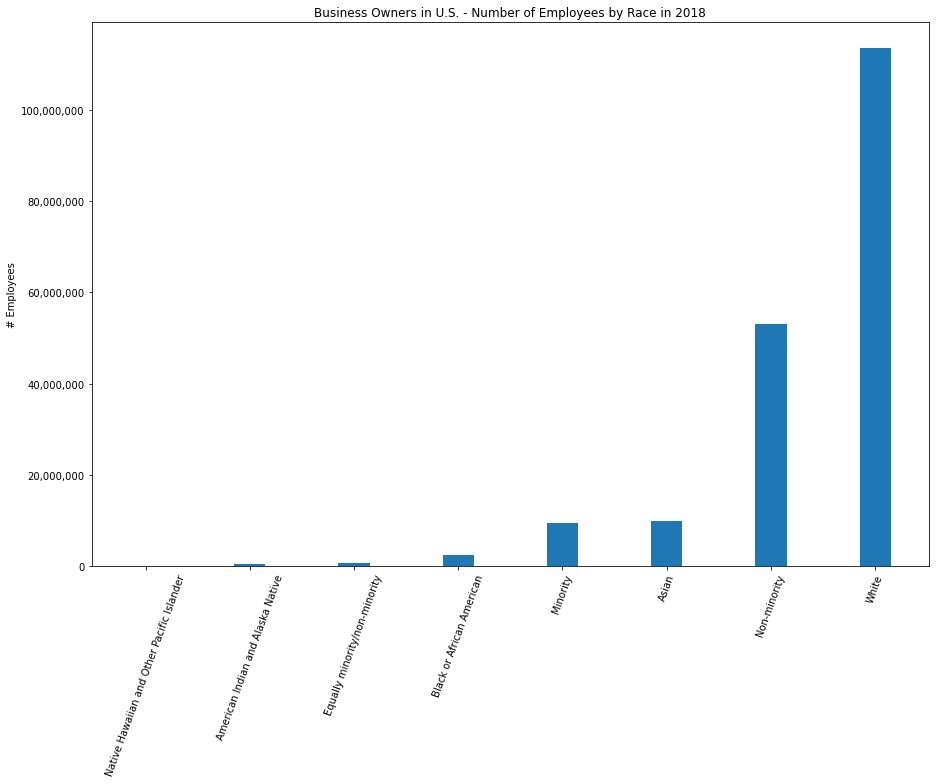

In [20]:
# plot 
plt.figure(figsize=(15,10))
plt.bar(race_chart.index, race_chart["EMP"], width = 0.3)
x = plt.gca().xaxis

# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(70)

ax = plt.gca()
#ax.set_xlabel('Date')
ax.set_ylabel('# Employees')
ax.set_title('Business Owners in U.S. - Number of Employees by Race in 2018')

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig('businessOwnnerRace.png', facecolor='white', transparent=False)

In [11]:
# create ethnicity chart
eth_chart = busState[["EMP", "ETH_GROUP_NAME"]].groupby("ETH_GROUP_NAME").sum()
eth_chart.sort_values(by = "EMP", inplace=True)
eth_chart

,EMP
ETH_GROUP_NAME,
Equally Hispanic/non-Hispanic,744000
Hispanic,5836431
Non-Hispanic,119730585
Total,254704763


In [12]:
# drop total from index
eth_chart.drop("Total", inplace=True)

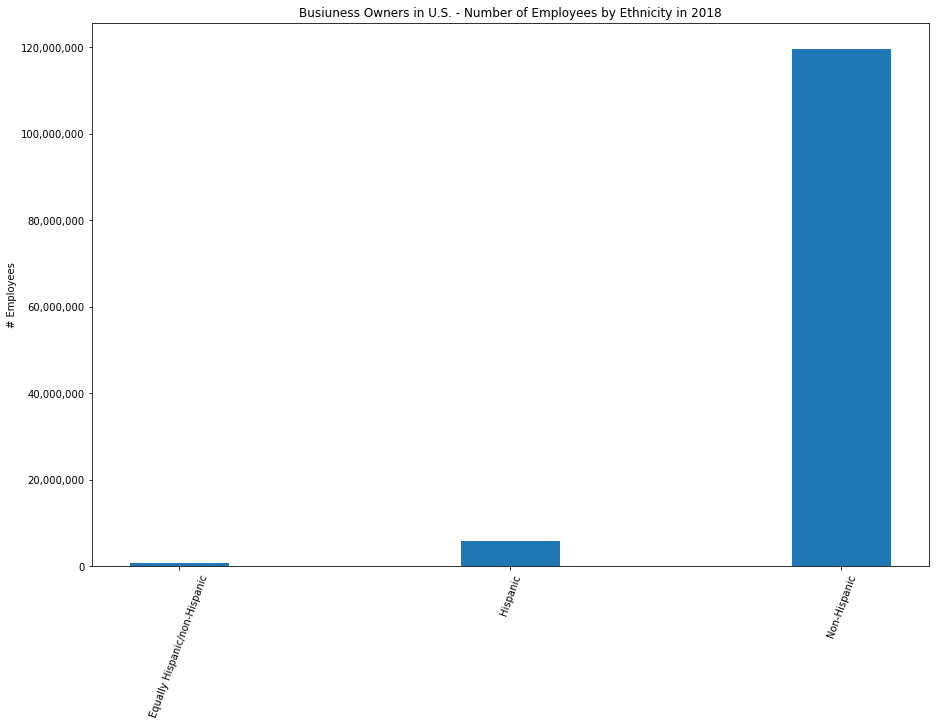

In [18]:
# plot ethnicity chart
plt.figure(figsize=(15,10))
plt.bar(eth_chart.index, eth_chart["EMP"], width = 0.3)
x = plt.gca().xaxis

# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(70)

ax = plt.gca()
#ax.set_xlabel('Date')
ax.set_ylabel('# Employees')
ax.set_title('Busiuness Owners in U.S. - Number of Employees by Ethnicity in 2018')

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig('businessOwnerEth.png', facecolor='white', transparent=False)

In [14]:
# create top 10 employees aggregated by state
state = busState[["EMP", "STATE_NAME"]].groupby("STATE_NAME").sum()
state.sort_values(by = "EMP", inplace=True)
state.head()

,EMP
STATE_NAME,
Vermont,720338
Wyoming,750941
Alaska,766643
South Dakota,992294
North Dakota,1012199


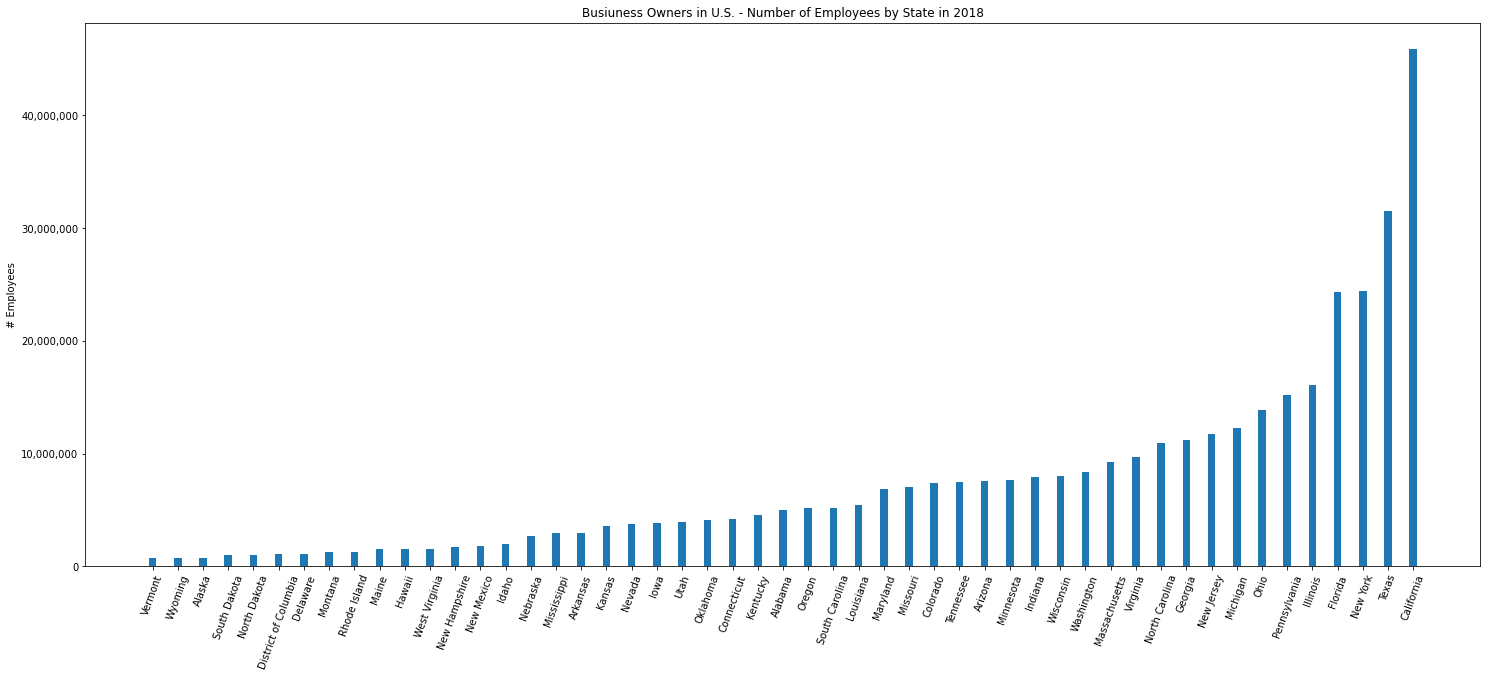

In [16]:
# plot employees by state chart
plt.figure(figsize=(25,10))
plt.bar(state.index, state["EMP"], width = 0.3)
x = plt.gca().xaxis

# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(70)

ax = plt.gca()
#ax.set_xlabel('Date')
ax.set_ylabel('# Employees')
ax.set_title('Busiuness Owners in U.S. - Number of Employees by State in 2018')

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('businessByState.png', facecolor='white', transparent=False)